Making a plot of weighted flux E^2 * phi, and event histograms, using the parameters gphi, Mphi, si that yields the lowest chi2 value compared to the HESE12 dataset (after subtracting the background).

Assuming the best fit parameters from the Bayesian analysis of MC events computed from the HESE 7.5 year dataset when taking the background.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.interpolate import interp1d
from scipy.special import factorial
import os
import sys
sys.path.append('/home/astridaurora/HESE-7-year-data-release/HESE-7-year-data-release')
from Astrid.effective_area import bin_edges_to_centers, bin_centers_to_edges, apply_energy_smearing

import nuSIprop



In [2]:
class SuppressOutput:
    """Suppress both Python and C++ prints to stdout and stderr."""
    def __enter__(self):
        # Save original stdout and stderr file descriptors
        self._original_stdout_fd = os.dup(1)
        self._original_stderr_fd = os.dup(2)

        # Open a null file descriptor (redirected to /dev/null)
        self._devnull = os.open(os.devnull, os.O_WRONLY)

        # Override stdout and stderr with the null file descriptor
        os.dup2(self._devnull, 1)
        os.dup2(self._devnull, 2)

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore original stdout and stderr file descriptors
        os.dup2(self._original_stdout_fd, 1)
        os.dup2(self._original_stderr_fd, 2)

        # Close the null file descriptor and original saved descriptors
        os.close(self._devnull)
        os.close(self._original_stdout_fd)
        os.close(self._original_stderr_fd)

In [3]:
"""def total_events(eff_df, flx_df, livetime, norm, delta_E):
    eff_interpolated = pd.DataFrame(
        {col: interp1d(
            eff_df.index, 
            eff_df[col], 
            bounds_error=False, 
            fill_value="extrapolate")(flx_df.index) 
            for col in eff_df.columns
        },
        index=flx_df.index
    )
    if eff_df['nu_e'].any().sum() < 0:
        print('Negative effective area found')
    if eff_df['nu_mu'].any().sum() < 0:
        print('Negative effective area found')
    if eff_df['nu_tau'].any().sum() < 0:
        print('Negative effective area found')

    nuSIprop_events_df = eff_interpolated * flx_df * livetime * norm 
    negative_mask = nuSIprop_events_df < 0
    nuSIprop_events_df[negative_mask] = 0
        
    nuSIprop_events_df['total_events'] = delta_E * (nuSIprop_events_df['nu_e'] + nuSIprop_events_df['nu_mu'] + nuSIprop_events_df['nu_tau'])
    return nuSIprop_events_df['total_events']"""
    
    
def total_events(flx, eff, livetime, norm, delta_E, save_to_csv=False):
    # Interpolate `flx` to the same energy bins as `eff`
    flx_interpolated = pd.DataFrame(
    {col: interp1d(flx.index, flx[col], bounds_error=False, fill_value="extrapolate")(eff.index)
     for col in flx.columns},
    index=eff.index)
    
    """if eff['nu_e'].any() < 0:
        continue
    elif eff['nu_mu'].any() < 0:
        continue
    elif eff['nu_tau'].any() < 0:
        print('Negative effective area found')"""
    

    total_events_df = flx_interpolated * eff * livetime * norm 
    negative_mask = total_events_df < 0
    total_events_df[negative_mask] = 0
        
    #total_events_df = flx * eff_interpolated * livetime
    total_events_df['total_events'] = delta_E * (total_events_df['nu_e'] + total_events_df['nu_mu'] + total_events_df['nu_tau'])
    #total_events_df.index = eff.index 

    if save_to_csv==True:
        total_events_df.to_csv('total_events.csv')

    return total_events_df

In [4]:
def chi2_poisson(data, predicted):
    # Replace all zeros with 1e-8
    data = data.astype(float)
    data[np.where(data == 0)[0]] = 1e-8
        
    chi2_value = np.sum(2*(predicted - data) + 2*data*np.log(data/predicted))
    return chi2_value

def log_likelihood_poisson(data, predicted):
    # From Poisson distribution 
    return np.sum(-predicted + data*np.log(predicted) - np.log(factorial(data)))

In [5]:
energy_bins = np.logspace(4, 7, 3*20+1)
energy_centers = bin_edges_to_centers(energy_bins)
energy_bins_low_resolution = np.logspace(4, 7, 20+1)
energy_centers_low_resolution = bin_edges_to_centers(energy_bins_low_resolution)

livetime12 = 12*365*24*3600

Read the dataframes containing the HESE12 data, the scaled background from the 7.5 year MC events.

Replace all zeros in the HESE12 data to avoid numerical issues in Chi2 calculation. Dont want to completely want to remove them by grouping, as that removes the dips that we are looking for.

Multiply effective area by 1e4 to convert into cm. Lite oklart exakt hur enheterna är definierade.


In [6]:
hese12_events_df = pd.read_csv('4_to_7_HESE12/20bins/hese12_20bins_df.csv', index_col=0)

#print(hese12_events_df)

background_df = pd.read_csv('4_to_7_HESE12/20bins/background_20bins_df.csv', index_col=0)
background_df.rename(columns={'background': 'events'}, inplace=True)


effective_area_df = pd.read_csv('4_to_7_HESE12/60bins/effective_area_4_to_7.csv', index_col=0)
#effective_area_df.index = effective_area_df.index * 1e9    # Convert to [eV]   
#effective_area_df['nu_e'] = effective_area_df['nu_e'] * 1e4
#effective_area_df['nu_mu'] = effective_area_df['nu_mu'] * 1e4
#effective_area_df['nu_tau'] = effective_area_df['nu_tau'] * 1e4
#effective_area_df['total'] = effective_area_df['nu_e'] + effective_area_df['nu_mu'] + effective_area_df['nu_tau']

print(effective_area_df)


                    nu_e      nu_mu     nu_tau
1.059254e+04    0.000000   0.000000   0.000000
1.188502e+04    0.000000   0.000000   0.000000
1.333521e+04    0.000650   0.000000   0.000000
1.496236e+04    0.001655   0.000000   0.000164
1.678804e+04    0.005214   0.000231   0.000910
1.883649e+04    0.022066   0.001210   0.002558
2.113489e+04    0.043136   0.004113   0.009679
2.371374e+04    0.093632   0.006964   0.016494
2.660725e+04    0.158180   0.013907   0.046911
2.985383e+04    0.259070   0.030709   0.078405
3.349654e+04    0.390221   0.054082   0.131141
3.758374e+04    0.553705   0.082374   0.226340
4.216965e+04    0.774678   0.129672   0.341698
4.731513e+04    1.092296   0.216925   0.507006
5.308844e+04    1.616033   0.291094   0.687900
5.956621e+04    2.114926   0.452367   0.961127
6.683439e+04    2.826941   0.654275   1.425661
7.498942e+04    3.440951   0.891118   1.751250
8.413951e+04    4.221091   1.235720   2.431535
9.440609e+04    5.163777   1.650396   2.969325
1.059254e+05 

In [7]:
dof = len(hese12_events_df) - 1
chi2_critical = chi2.ppf(0.95, df=dof)  # 2 sigma confidence level
print('chi2 critical', chi2_critical)

chi2 critical 30.14352720564616


In [8]:
total_energy = (hese12_events_df.index.values * hese12_events_df['events']).sum()
print(total_energy)
total_log_energy = np.log10(total_energy)
print(total_log_energy)

total_energy_background = (background_df.index.values * background_df['events']).sum()
total_log_energy_background = np.log10(total_energy_background)
print(total_energy_background)
print(total_log_energy_background)

#print(background_df.index.values)
#print(hese12_events_df.index.values)
#assert background_df.index.values.sum() == hese12_events_df.index.values.sum()

23421481.002200443
7.369614353193542
3466660.958276703
6.539911369447108


Initialize the nuSIprop object, and then later updating g, M and si inside the loops.

In [10]:
#norm = 6.36488608 * 1e-18 # Best fit for astro norm
norm = 4.0*1e-18    # Same norm used in the nuSIprop paper
si_grid = np.linspace(2.0, 3.0, num=14)  
si_marginalized = []

#norm_grid = np.linspace(1.0, 10, num=7)
#norm_marginalized = []

mntot_grid = np.linspace(0.05, 0.12, num=7)
mntot_marginalized = []
mntot = 0.1

g_phi = np.logspace(-4, 0, num=20)
M_phi = np.logspace(-1, 3, num=20)
chi2_grid = np.zeros(shape=(len(g_phi), len(M_phi)))

evolver = nuSIprop.pyprop(mphi = M_phi[0]*1e6, # Mediator mass [eV]
			  g = g_phi[0], # Coupling
			  mntot = mntot, # Sum of neutrino masses [eV]
			  si = si_grid[0], # Spectral index
			  norm = norm, # Normalization of the free-streaming flux at 100 TeV [Default = 1]
			  majorana = True, # Majorana neutrinos? [Default = True]
			  non_resonant = True, # Include non s-channel contributions? Relevant for couplings g>~0.1 [Default = True]
			  normal_ordering = True, # Normal neutrino mass ordering? [Default = True]
			  N_bins_E = 300, # Number of energy bins, uniformly distributed in log space [Default = 300]
			  lEmin = 13, # log_10 (E_min/eV) [Default = 13]
			  lEmax = 16, # log_10 (E_max/eV) [Default = 17]
			  zmax = 5, # Largest redshift at which sources are included [Default = 5]
			  flav = 2, # Flavor of interacting neutrinos [0=e, 1=mu, 2=tau. Default = 2]
			  phiphi = False # Consider double-scalar production? If set to true, the files xsec/alpha_phiphi.bin and xsec/alphatilde_phiphi.bin must exist [Default = False]
                          )
evolver.evolve()
flx = evolver.get_flux_fla()
energies = evolver.get_energies()
bin_edges_high_resolution = bin_centers_to_edges(energies)
delta_E = np.diff(bin_edges_high_resolution)    # Delta E in eV

Doing a similar procedure but using new chi2 formula made for low event counts.

DONT group events, as that will avoid the dips in the spectrum that we are looking for.

Data = HESE12
Preducted = nuSIprop + Bkg_mc

In [9]:
for g_idx, g in enumerate(g_phi):
    for M_idx, M in enumerate(M_phi):
        chi2_si = []
        for si_idx, si_ in enumerate(si_grid):
            #print(f'g = {g}, M = {M}, si = {si_}')

            with SuppressOutput():
                evolver.set_parameters(g=g, mphi=M*1e6, si=si_)
                evolver.evolve()

            flx = evolver.get_flux_fla()
            flx_df = pd.DataFrame(flx.T, index=evolver.get_energies(), columns=['nu_e', 'nu_mu', 'nu_tau'])
            flx_df.index = flx_df.index / 1e9    # Convert to [GeV] to align with eff_df. 

            # Get total number of events by multiplying the effective area with the flux.
            # norm = 1e-4 to compensate for that [Aeff] = [m^2], and [Flux] = [eV^-1 cm^-2 s^-1 sr^-1] (possibly?...)
            nuSIprop_df = total_events(flx=effective_area_df, eff=flx_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
            nuSIprop_events = nuSIprop_df['total_events']
            nuSIprop_smeared = apply_energy_smearing(energies=nuSIprop_df.index.values, events=nuSIprop_events.values, resolution=0.1)
            
            # Bin the nuSIprop events according to the low resolution energy bins, to be compared with the HESE12 data.
            nuSIprop_binned_events, _ = np.histogram(a=nuSIprop_df.index.values, weights=nuSIprop_smeared, bins=energy_bins_low_resolution)
            #nuSIprop_binned_df = pd.DataFrame(nuSIprop_binned_events, index=energy_centers_low_resolution, columns=['events'])

            # Add the background events to the nuSIprop events. 
            predicted = nuSIprop_binned_events + background_df['events'].values
            #print('total predicted events', predicted.sum())
            #print('min predicted event', np.min(predicted))

    
            # Total approximate energy of the predicted events, in GeV.
            #predicted_log_energy = np.log10((predicted * energy_centers_low_resolution).sum())
            #print('predicted_log_energy', predicted_log_energy)

            # Compute the chi2 value for the given g, M and si.
            chi2_  = chi2_poisson(data=hese12_events_df['events'].values, predicted=predicted)
            chi2_si.append(chi2_)

        print('chi2_si', chi2_si)
        chi2_grid[g_idx, M_idx] = np.min(chi2_si)
        si_min = si_grid[np.argmin(chi2_si)]
        print(f'Minimum si for g={g}, M={M}: si = {si_min}')
        print('chi2_grid', chi2_grid)
        si_marginalized.append(si_min)

chi2_si [252.33124318775907, 202.2560947124345, 162.51156163659758, 130.8463980978018, 105.54328999015223, 85.28675816203956, 69.06485730127747, 56.095865011494865, 45.773484579459655, 37.625791405120445, 31.284404728831607, 26.461285390482647, 22.931236067230085, 20.518677862808293]
Minimum si for g=0.0001, M=0.1: si = 3.0
chi2_grid [[20.51867786  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0

In [16]:
chi2_grid =  [[ 20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786,
   21.72314817,  20.97023251,  20.83271934,  19.78109001,  20.36231491,
   20.54725485,  20.52284456,  20.51813763,  20.51862349,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786,
   22.34051674,  22.6040208,   21.55830042,  19.05343315,  20.18914131,
   20.59192808,  20.5292247,   20.51725718,  20.51853585,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51867783,  20.51867783,  20.51867783,  20.51867783,  20.51867783,
   22.71720873,  24.83061078,  22.93184885,  18.1234107,   19.97560282,
   20.69901119,  20.54389998,  20.51495762,  20.51831236,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51867762,  20.51867762,  20.51867763,  20.51867763,  20.51867763,
   22.88131035,  26.46461333,  24.53071735,  17.31339661,  19.90180467,
   20.92424991,  20.57250385,  20.50903931,  20.51777097,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51867617,  20.51867619,  20.51867622,  20.51867627,  20.51867624,
   22.94449832,  27.27092149,  25.71876828,  16.85582777,  20.05691904,
   21.28559501,  20.61415887,  20.49434681,  20.51660486,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51866611,  20.51866621,  20.51866641,  20.51866677,  20.51866654,
   22.96832296,  27.60492497,  26.34721106,  16.68994198,  20.24109759,
   21.67282069,  20.65734603,  20.46135074,  20.51461126,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51859616,  20.51859687,  20.51859828,  20.51860073,  20.51859918,
   22.97741346,  27.73613743,  26.62251784,  16.64678004,  20.31914774,
   21.95428888,  20.70665072,  20.40407759,  20.51222596,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51811042,  20.51811534,  20.51812508,  20.51814207,  20.51813126,
   22.98153591,  27.79227839,  26.73850554,  16.63707517,  20.3364987,
   22.11169265,  20.77197727,  20.33907451,  20.51033077,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.51475836,  20.51479163,  20.51485761,  20.51497289,  20.51489678,
   22.9876937,   27.85417903,  26.82173807,  16.63710858,  20.33350154,
   22.18624751,  20.82894634,  20.29179288,  20.50926178,  20.51867786,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.49263922,  20.49282683,  20.49320211,  20.4938711,   20.49329601,
   23.01645653,  28.14965169,  27.10702941,  16.64359808,  20.30001386,
   22.22022858,  20.86229009,  20.26699033,  20.50877166,  20.51867783,
   20.51867786,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 20.39194105,  20.39138544,  20.39042715,  20.38934038,  20.3830298,
   23.09770091,  29.86805463,  28.63397541,  16.60832027,  20.19342884,
   22.25007885,  20.88062461,  20.25618388,  20.50854593,  20.51867762,
   20.51867784,  20.51867786,  20.51867786,  20.51867786,  20.51867786],
 [ 21.35252116,  21.30540641,  21.21330197,  21.05878936,  20.91288408,
   23.9021597,   37.83537712,  35.40544129,  16.79187882,  19.93671866,
   22.34804841,  20.90900405,  20.25211607,  20.50828884,  20.51867617,
   20.51867771,  20.51867784,  20.51867786,  20.51867787,  20.51867787],
 [ 41.88194442,  41.53156444,  40.81706785,  39.4745047,   37.7030285,
   40.01746112,  66.5930381,   60.98571215,  19.15298679,  19.22382018,
   22.69242661,  21.03620909,  20.25178755,  20.50717275,  20.51866611,
   20.51867682,  20.51867773,  20.51867785,  20.51867788,  20.51867791],
 [105.62985903, 105.20677286, 104.33410588, 102.59084749,  99.70198767,
   98.92748582, 118.58224683, 114.71314154,  32.93452302,  18.9311965,
   23.79977673,  21.58826869,  20.25804523,  20.50243865,  20.51859629,
   20.51867062,  20.51867693,  20.51867777,  20.51867795,  20.5186782 ],
 [154.57815507, 154.36745307, 153.93773658, 153.07137555, 151.49292999,
   150.04152437, 156.09670465, 159.24038591,  70.52118466,  20.3341574,
   26.28103099,  23.42740461,  20.34438741,  20.4889462,   20.51811598,
   20.51862756,  20.51867139,  20.51867721,  20.51867847,  20.51868022],
 [176.66859817, 176.56801761, 176.36432633, 175.95557279, 175.17669043,
   174.10813122, 175.03757927, 178.12496199, 127.96808048,  23.62645558,
   29.86237404,  26.40748338,  20.80597258,  20.46943085,  20.51502266,
   20.51833032,  20.51863293,  20.51867329,  20.51868208,  20.51869424],
 [199.71308115, 199.67931548, 199.60970501, 199.46810645, 199.18687486,
   198.69591967, 198.27001111, 198.47629293, 188.57841649,  93.29611179,
   31.00078728,  28.34553917,  21.59789389,  20.50957401,  20.50233381,
   20.51636432,  20.5183673,   20.51864612,  20.5187072,   20.51879185],
 [215.37285184, 215.36130061, 215.33705645, 215.28709793, 215.18572809,
   214.99006306, 214.68487381, 214.36749735, 212.98731916, 187.01364169,
   81.24733474,  30.08288497,  22.11684609,  20.73090031,  20.5060172,
   20.50678718,  20.51660465,  20.51845908,  20.51888298,  20.51947762],
 [224.28361034, 224.27965003, 224.27118282, 224.25346415, 224.21695299,
   224.14323953, 224.00554589, 223.7873954,  223.42850364, 219.53639693,
   183.98669842,  72.5757414,   24.01369346,  20.9348125,   20.5734382,
   20.50478943,  20.50781987,  20.51724561,  20.52015939,  20.5245954 ],
 [228.88842273, 228.88711403, 228.88427345, 228.87824613, 228.86567276,
   228.83972791, 228.78766041, 228.69129007, 228.54097049, 228.01810394,
   222.47775539, 177.03713726,  64.55057403,  23.01847696,  20.68964533,
   20.53704921,  20.50553589,  20.51245965,  20.53171618,  20.57801876]]

chi2_grid = np.array(chi2_grid)

In [17]:
print(chi2_grid)
print(si_marginalized)

chi2_min = np.min(chi2_grid)
print('chi2 min', chi2_min)
print(np.argmin(chi2_grid))
#si_min = si_marginalized[np.argmin(chi2_grid)]
#print(si_min)
# Convert the flat index to row and column indices
row, col = np.unravel_index(np.argmin(chi2_grid), chi2_grid.shape)

g_min = g_phi[row]
M_min = M_phi[col]

print('g_min', g_min)
print('M_min', M_min)
#print('si_min', si_min)

[[ 20.51867786  20.51867786  20.51867786  20.51867786  20.51867786
   21.72314817  20.97023251  20.83271934  19.78109001  20.36231491
   20.54725485  20.52284456  20.51813763  20.51862349  20.51867786
   20.51867786  20.51867786  20.51867786  20.51867786  20.51867786]
 [ 20.51867786  20.51867786  20.51867786  20.51867786  20.51867786
   22.34051674  22.6040208   21.55830042  19.05343315  20.18914131
   20.59192808  20.5292247   20.51725718  20.51853585  20.51867786
   20.51867786  20.51867786  20.51867786  20.51867786  20.51867786]
 [ 20.51867783  20.51867783  20.51867783  20.51867783  20.51867783
   22.71720873  24.83061078  22.93184885  18.1234107   19.97560282
   20.69901119  20.54389998  20.51495762  20.51831236  20.51867786
   20.51867786  20.51867786  20.51867786  20.51867786  20.51867786]
 [ 20.51867762  20.51867762  20.51867763  20.51867763  20.51867763
   22.88131035  26.46461333  24.53071735  17.31339661  19.90180467
   20.92424991  20.57250385  20.50903931  20.51777097  20.5

          0.100000     0.162378     0.263665     0.428133     0.695193     \
0.000100    20.518678    20.518678    20.518678    20.518678    20.518678   
0.000162    20.518678    20.518678    20.518678    20.518678    20.518678   
0.000264    20.518678    20.518678    20.518678    20.518678    20.518678   
0.000428    20.518678    20.518678    20.518678    20.518678    20.518678   
0.000695    20.518676    20.518676    20.518676    20.518676    20.518676   
0.001129    20.518666    20.518666    20.518666    20.518667    20.518667   
0.001833    20.518596    20.518597    20.518598    20.518601    20.518599   
0.002976    20.518110    20.518115    20.518125    20.518142    20.518131   
0.004833    20.514758    20.514792    20.514858    20.514973    20.514897   
0.007848    20.492639    20.492827    20.493202    20.493871    20.493296   
0.012743    20.391941    20.391385    20.390427    20.389340    20.383030   
0.020691    21.352521    21.305406    21.213302    21.058789    20.912884   

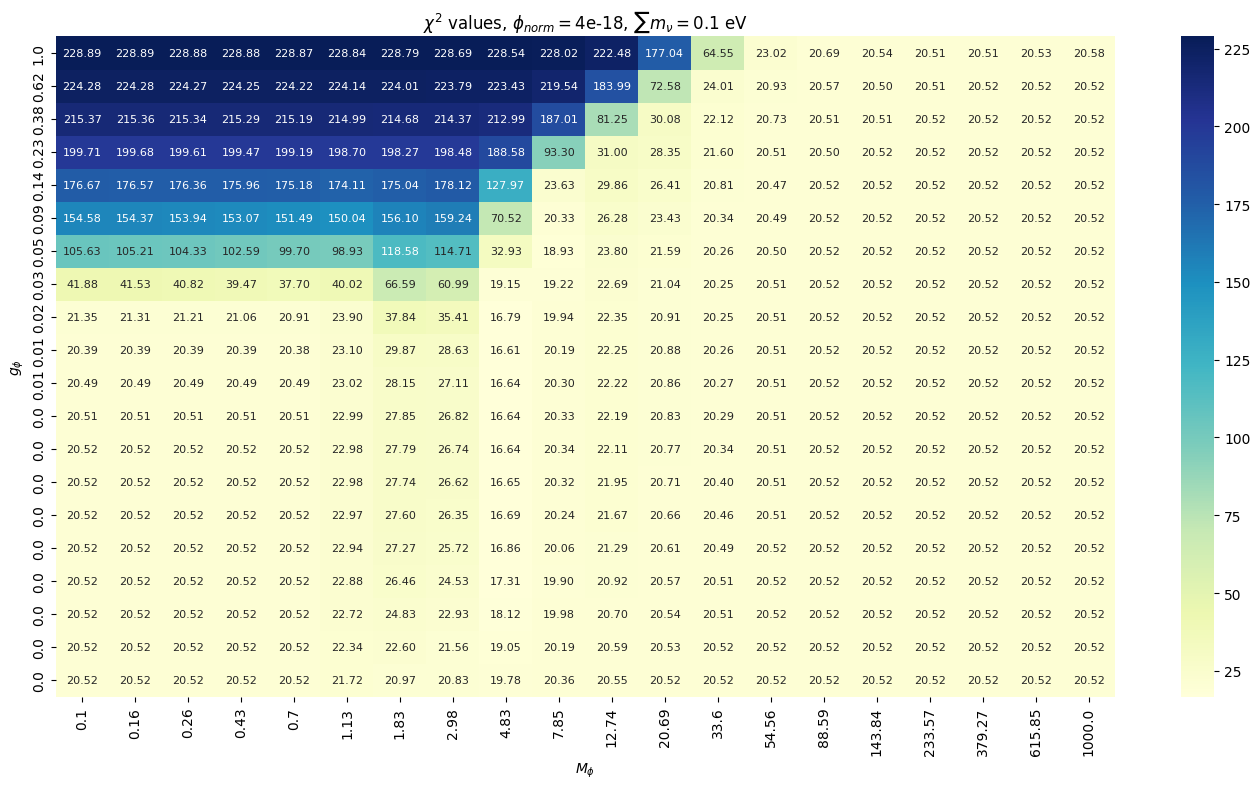

In [25]:
chi2_df = pd.DataFrame(chi2_grid, index=g_phi, columns=M_phi)
chi2_df.to_csv('plots/frequentist/chi2_grid_norm4.csv')

print(chi2_df)
"""heatmap_data = chi2_df.pivot(index=chi2_df.index, columns=chi2_df.columns, values=chi2_grid)
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.show()"""
M_phi_round = np.round(M_phi, 2)
g_phi_round = np.round(g_phi, 2)
print(M_phi_round)
print(g_phi_round)

plt.figure(figsize=(14, 8))
sns.heatmap(chi2_grid[::-1], 
            xticklabels=M_phi_round,
            yticklabels=g_phi_round[::-1],
            annot=True,
            annot_kws={"size": 8},
            cmap="YlGnBu",
            fmt='.2f'
            )
plt.xlabel(r'$M_\phi$')
plt.ylabel(r'$g_\phi$')
#plt.xscale('log')
#plt.yscale('log')
mntot = 0.1
plt.title(r'$\chi^2$' + ' values, ' + r'$\phi_{norm} = $' + str(np.round(norm, 19)) + ', ' + r'$\sum m_{\nu} = $' + str(mntot) + ' eV')
plt.tight_layout()
plt.show()

Using 5 iterations over g, M and si yields a lowest chi2 value of 14.72427087 for g=1.0, M=200.0, si=2.25.
Modifying the dataframe to group indices (0,1), (14,15), (16,17,18,19) to avoid numerical issues from zeros in chi2 calculation yields lowest chi2 value of 12.2 for g=1.0, M=46, si=2.5.

Using (10, 10, 7) iterations for (M, g, si) yields best fit for g=0.1, M = 21, si = 2.888 (extended upped bound of M to 500MeV). Chi2 = 11.88.

(15, 15, 10) iterations yields best fit for g=0.037, M=5.74, si=3.0. Using chi2_poisson, chi2_min = 16.80.

In [11]:
#norm = 6.36488608 * 1e-18 # Best fit for astro norm

# mphi = 14.2 MeV, g = 7.875e-4, si = 2.88, norm = 4.05e-18
M = 5.5
g=0.035
si = 3.0
norm = 4.0*1e-18

evolver = nuSIprop.pyprop(mphi = M*1e6, # Mediator mass [eV]
			  g = g, # Coupling
			  mntot = 0.1, # Sum of neutrino masses [eV]
			  si = si, # Spectral index
			  norm = norm, # Normalization of the free-streaming flux at 100 TeV [Default = 1]
			  majorana = True, # Majorana neutrinos? [Default = True]
			  non_resonant = True, # Include non s-channel contributions? Relevant for couplings g>~0.1 [Default = True]
			  normal_ordering = True, # Normal neutrino mass ordering? [Default = True]
			  N_bins_E = 300, # Number of energy bins, uniformly distributed in log space [Default = 300]
			  lEmin = 13, # log_10 (E_min/eV) [Default = 13]
			  lEmax = 16, # log_10 (E_max/eV) [Default = 17]
			  zmax = 5, # Largest redshift at which sources are included [Default = 5]
			  flav = 2, # Flavor of interacting neutrinos [0=e, 1=mu, 2=tau. Default = 2]
			  phiphi = False # Consider double-scalar production? If set to true, the files xsec/alpha_phiphi.bin and xsec/alphatilde_phiphi.bin must exist [Default = False]
                          )

evolver.evolve()

flx = evolver.get_flux_fla()
flx_df = pd.DataFrame(flx.T, index=evolver.get_energies(), columns=['nu_e', 'nu_mu', 'nu_tau'])
#flx_df['total'] = flx_df['nu_e'] + flx_df['nu_mu'] + flx_df['nu_tau']
energies = evolver.get_energies()
bin_edges_high_resolution = bin_centers_to_edges(energies)
delta_E = np.diff(bin_edges_high_resolution)    # Delta E in eV
flx_df.index = flx_df.index / 1e9    # Convert to [GeV] to align with eff_df. 

print(flx_df)

                      nu_e         nu_mu        nu_tau
1.011579e+04  1.278334e-15  1.279053e-15  1.278860e-15
1.035142e+04  1.193131e-15  1.193844e-15  1.193652e-15
1.059254e+04  1.113613e-15  1.114321e-15  1.114131e-15
1.083927e+04  1.039402e-15  1.040105e-15  1.039916e-15
1.109175e+04  9.701436e-16  9.708406e-16  9.706529e-16
...                    ...           ...           ...
9.015711e+06  1.770666e-24  1.759271e-24  1.762341e-24
9.225714e+06  1.652102e-24  1.641325e-24  1.644228e-24
9.440609e+06  1.541455e-24  1.531258e-24  1.534005e-24
9.660509e+06  1.438220e-24  1.428574e-24  1.431172e-24
9.885531e+06  1.341945e-24  1.332837e-24  1.335291e-24

[300 rows x 3 columns]


In [10]:
total_events_nuSIprop_df = total_events(flx=effective_area_df, eff=flx_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
#print(total_events_nuSIprop_df)

total_events_nuSIprop_smeared = apply_energy_smearing(energies=total_events_nuSIprop_df.index.values, events=total_events_nuSIprop_df['total_events'].values, resolution=0.1)
#print(total_events_nuSIprop_smeared)
nuSIprop_binned_events, _ = np.histogram(a=total_events_nuSIprop_df.index.values, weights=total_events_nuSIprop_smeared, bins=energy_bins_low_resolution)

print(nuSIprop_binned_events)
predicted_nuSIprop = nuSIprop_binned_events + background_df['events'].values
print(predicted_nuSIprop)

ll = log_likelihood_poisson(data=hese12_events_df['events'].values, predicted=predicted_nuSIprop)
print(ll)

#nuSIprop_binned_events, _ = np.histogram(nuSIprop_df.index.values, weights=nuSIprop_smeared, bins=energy_bins_low_resolution)

[ 0.03806828  0.67412848  3.43964964  8.23111952 14.0555941  19.63121554
 20.94466177 15.81559662  7.4818662   2.87839587  3.96080826  1.29079007
  1.21578995  1.6015024   1.08666405  0.69720235  0.43888388  0.31980917
  0.55788069  0.1748243 ]
[ 0.07977109  1.78603682 12.11372178 30.07414236 25.01139577 26.97875271
 26.21010469 18.79298008  8.94092923  3.43870608  4.18484809  1.38615926
  1.24872909  1.61358242  1.09017228  0.69846018  0.43931286  0.31995834
  0.55794573  0.17483751]
-32.27423011225599


chi2 12.280012753391242


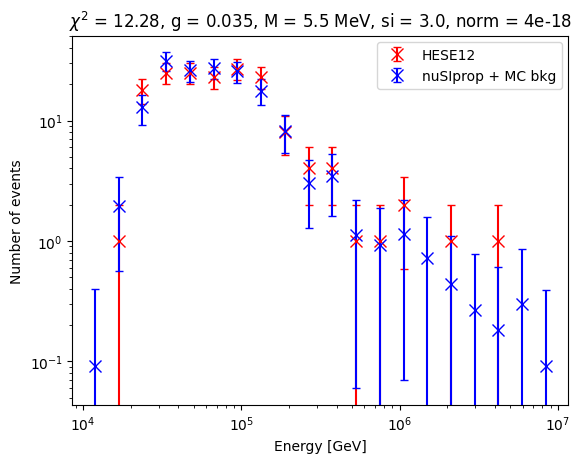

                 events
1.188502e+04   0.050423
1.678804e+04   0.856396
2.371374e+04   4.175310
3.349654e+04   9.479532
4.731513e+04  15.289151
6.683439e+04  20.200753
9.440609e+04  20.477806
1.333521e+05  14.803438
1.883649e+05   6.743759
2.660725e+05   2.449093
3.758374e+05   3.235832
5.308844e+05   1.020648
7.498942e+05   0.887848
1.059254e+06   1.123931
1.496236e+06   0.724657
2.113489e+06   0.441584
2.985383e+06   0.263879
4.216965e+06   0.181791
5.956621e+06   0.301060
8.413951e+06   0.091268
164
60.60609523231524
163.40425485170803


In [12]:
# Possible factor 1e5 (and times 4pi eventually?..) to compensate for the m^2 to cm^2 conversion and the 1e9 factor from GeV to eV

total_events_nuSIprop_df = total_events(flx=effective_area_df, eff=flx_df, livetime=livetime12, norm=1e-4, delta_E=delta_E)
total_events_nuSIprop_smeared = apply_energy_smearing(energies=total_events_nuSIprop_df.index.values, events=total_events_nuSIprop_df['total_events'].values, resolution=0.1)

nuSIprop_binned_events, _ = np.histogram(a=total_events_nuSIprop_df.index.values, weights=total_events_nuSIprop_smeared, bins=energy_bins_low_resolution)
nuSIprop_binned_df = pd.DataFrame(nuSIprop_binned_events, index=energy_centers_low_resolution, columns=['events'])

predicted_nuSIprop = nuSIprop_binned_df['events'].values + background_df['events'].values
chi2_ = chi2_poisson(data=hese12_events_df['events'].values, predicted=predicted_nuSIprop)
print('chi2', chi2_)
plt.errorbar(hese12_events_df.index.values, hese12_events_df['events'].values, yerr=np.sqrt(hese12_events_df['events'].values), 
             fmt='x', color='red', label='HESE12', capsize=3, markersize=8, linestyle='none')
plt.errorbar(nuSIprop_binned_df.index.values, predicted_nuSIprop, yerr=np.sqrt(predicted_nuSIprop), 
             fmt='x', color='blue', label='nuSIprop + MC bkg', capsize=3, markersize=8, linestyle='none')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-1, 1e2)
plt.xlabel('Energy [GeV]')
plt.ylabel('Number of events')
#plt.title(r'$\chi^2$ = ' + str(np.round(chi2_, 2)) + ', g = 7.875e-4, M = 14.2 MeV, si = 2.88, norm = 4.05')
plt.title(r'$\chi^2$ = ' + str(np.round(chi2_, 2)) + ', g = ' + str(g) + ', M = ' + str(M) + ' MeV, si = ' + str(si) + ', norm = ' + str(np.round(norm, 20)))
plt.legend()
plt.show()

print(nuSIprop_binned_df)
print(hese12_events_df['events'].sum())
print(background_df['events'].sum())
print(predicted_nuSIprop.sum())

#plt.savefig('nuSIprop_vs_HESE12.png', dpi=150, bbox_inches='tight')







In [26]:
exclusion_g = []
for m_idx, M in enumerate(M_phi):
    above = np.where(chi2_grid[:, m_idx] > chi2_critical)[0]
    print(above)
    if len(above) > 0:
        exclusion_g.append(g_phi[above[0]])
        print('Exclusion g: ', g_phi[above[0]])
        print(above[0])
    else:
        exclusion_g.append(np.nan)
print('Exclusion g: ', exclusion_g)

[12 13 14 15 16 17 18 19]
Exclusion g:  0.03359818286283781
12
[12 13 14 15 16 17 18 19]
Exclusion g:  0.03359818286283781
12
[12 13 14 15 16 17 18 19]
Exclusion g:  0.03359818286283781
12
[12 13 14 15 16 17 18 19]
Exclusion g:  0.03359818286283781
12
[12 13 14 15 16 17 18 19]
Exclusion g:  0.03359818286283781
12
[12 13 14 15 16 17 18 19]
Exclusion g:  0.03359818286283781
12
[11 12 13 14 15 16 17 18 19]
Exclusion g:  0.0206913808111479
11
[11 12 13 14 15 16 17 18 19]
Exclusion g:  0.0206913808111479
11
[13 14 15 16 17 18 19]
Exclusion g:  0.05455594781168514
13
[16 17 18 19]
Exclusion g:  0.23357214690901212
16
[16 17 18 19]
Exclusion g:  0.23357214690901212
16
[18 19]
Exclusion g:  0.615848211066026
18
[19]
Exclusion g:  1.0
19
[]
[]
[]
[]
[]
[]
[]
Exclusion g:  [0.03359818286283781, 0.03359818286283781, 0.03359818286283781, 0.03359818286283781, 0.03359818286283781, 0.03359818286283781, 0.0206913808111479, 0.0206913808111479, 0.05455594781168514, 0.23357214690901212, 0.233572146909012

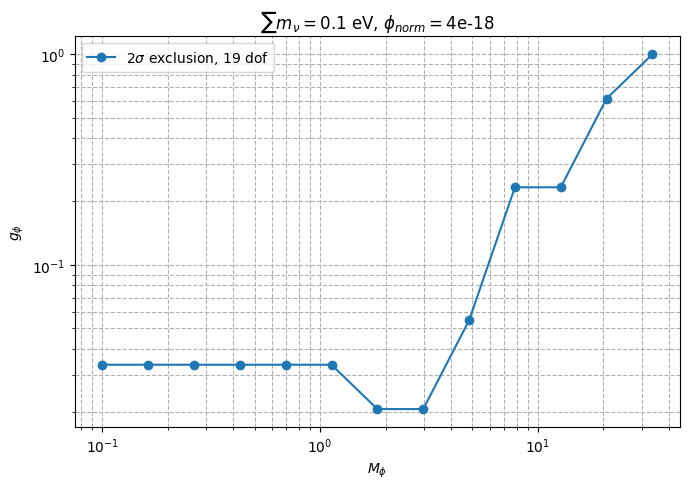

In [28]:
# Plotting the exclusion limit
plt.figure(figsize=(7,5))
plt.plot(M_phi, exclusion_g, linestyle='-', marker='o', label=r'2$\sigma$ exclusion, ' + str(dof) + ' dof')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_\phi$')
plt.ylabel(r'$g_\phi$')
plt.title(r'$\sum m_{\nu} = $' + str(mntot) + ' eV, ' + r'$\phi_{norm} = $' + str(np.round(norm, 19)))
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()

Now doing the same procedure, but for the weighted flux E^2 * phi.

In [38]:

si_grid = np.linspace(2.0, 3.0, num=10)  
si_marginalized = []

norm_grid = np.linspace(1.0, 10, num=7)
norm_marginalized = []

mntot_grid = np.linspace(0.05, 0.12, num=7)
mntot_marginalized = []

print(norm_grid)
print(mntot_grid)
print(si_grid)

g_phi = np.logspace(-4, 0, num=10)
M_phi = np.logspace(np.log10(4*1e-1), np.log10(5*1e2), num=10)
chi2_grid = np.zeros(shape=(len(g_phi), len(M_phi)))

print(M_phi)

[ 1.   2.5  4.   5.5  7.   8.5 10. ]
[0.05       0.06166667 0.07333333 0.085      0.09666667 0.10833333
 0.12      ]
[2.         2.11111111 2.22222222 2.33333333 2.44444444 2.55555556
 2.66666667 2.77777778 2.88888889 3.        ]
[4.00000000e-01 8.83407544e-01 1.95102222e+00 4.30886938e+00
 9.51621930e+00 2.10167498e+01 4.64158883e+01 1.02510365e+02
 2.26396074e+02 5.00000000e+02]


In [39]:
#norm = 6.36488608 * 1e-18 # Best fit for astro norm
norm = 5*1e-18    # Same norm used in the nuSIprop paper

evolver = nuSIprop.pyprop(mphi = M_phi[0]*1e6, # Mediator mass [eV]
			  g = g_phi[0], # Coupling
			  mntot = 0.1, # Sum of neutrino masses [eV]
			  si = si_grid[0], # Spectral index
			  norm = norm, # Normalization of the free-streaming flux at 100 TeV [Default = 1]
			  majorana = True, # Majorana neutrinos? [Default = True]
			  non_resonant = True, # Include non s-channel contributions? Relevant for couplings g>~0.1 [Default = True]
			  normal_ordering = True, # Normal neutrino mass ordering? [Default = True]
			  N_bins_E = 300, # Number of energy bins, uniformly distributed in log space [Default = 300]
			  lEmin = 13, # log_10 (E_min/eV) [Default = 13]
			  lEmax = 16, # log_10 (E_max/eV) [Default = 17]
			  zmax = 5, # Largest redshift at which sources are included [Default = 5]
			  flav = 2, # Flavor of interacting neutrinos [0=e, 1=mu, 2=tau. Default = 2]
			  phiphi = False # Consider double-scalar production? If set to true, the files xsec/alpha_phiphi.bin and xsec/alphatilde_phiphi.bin must exist [Default = False]
                          )

In [42]:
print(background_grouped_df)
print(len(background_grouped_df))
background_flux = background_grouped_df['events'].values / (delta_E * eff_tot_binned * livetime12 * 4*np.pi * 1e4)
print(background_flux)

                 events
1.412538e+04   1.153611
2.371374e+04   8.674072
3.349654e+04  21.843023
4.731513e+04  10.955802
6.683439e+04   7.347537
9.440609e+04   5.265443
1.333521e+05   2.977383
1.883649e+05   1.459063
2.660725e+05   0.560310
3.758374e+05   0.224040
5.308844e+05   0.095369
7.498942e+05   0.032939
1.059254e+06   0.012080
1.778279e+06   0.004766
5.011872e+06   0.000656
15


NameError: name 'eff_tot_binned' is not defined

In [ ]:

for g_idx, g in enumerate(g_phi):
    for M_idx, M in enumerate(M_phi):
        chi2_si = []
        for si_idx, si_ in enumerate(si_grid):
            print(f'g = {g}, M = {M}, si = {si_}')

            with SuppressOutput():
                evolver.set_parameters(g=g, mphi=M*1e6, si=si_)
                evolver.evolve()

            flx = evolver.get_flux_fla()
            flx_df = pd.DataFrame(flx.T, index=evolver.get_energies(), columns=['nu_e', 'nu_mu', 'nu_tau'])
            bin_edges_high_resolution = bin_centers_to_edges(flx_df.index.values)
            delta_E = np.diff(bin_edges_high_resolution)    # Delta E in eV
            #flx_df.index = flx_df.index / 1e9    # Convert to [GeV] to align with eff_df. 

            flx_weighted = flx_df.index.values*(flx_df['nu_e'] + flx_df['nu_mu'] + flx_df['nu_tau'])
            flx_weighted_binned, _ = np.histogram(flx_weighted, bins=energy_bins_low_resolution)
            flx_grouped = group_events(flx_weighted_binned)
            

            
            # Group the nuSIprop events manually, as equal to the HESE12 data
            # to avoid numerical issues from zeros in chi2 calculation.
            #nuSIprop_grouped_df = group_events(nuSIprop_binned_df)
            assert np.round(nuSIprop_grouped_df['events'].sum(), 10) == np.round(nuSIprop_binned_df['events'].sum(), 10)
            
            # Add the background events to the nuSIprop events. 
            predicted = nuSIprop_grouped_df['events'].values + background_grouped_df['events'].values
            print('total predicted events', predicted.sum())

            # Compute the chi2 value for the given g, M and si.
            chi2_, p_value = compute_chi2(observed=hese12_grouped_df['events'].values, expected=predicted)
            chi2_si.append(chi2_)

        print('chi2_si', chi2_si)
        chi2_grid[g_idx, M_idx] = np.min(chi2_si)
        si_min = si_grid[np.argmin(chi2_si)]
        print(f'Minimum si for g={g}, M={M}: si = {si_min}')
        print('chi2_grid', chi2_grid)
        si_marginalized.append(si_min)